## Aondokator Joseph 1239205 Project 2
Exploring Textual Data Analysis Using SpaCy

**Dataset Deescription:**
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. 

In [1]:
import kaggle as kg
import spacy
from sklearn.model_selection import train_test_split
import pandas as pd
import en_core_web_lg
import emoji
import re
import random
from spacy.util import minibatch
import spacy.training
from spacy.pipeline.textcat import Config, single_label_cnn_config
from spacy.training.example import Example
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer 
import numpy as np 
# spacy.prefer_gpu() # for GPU acceleration

C:\Users\aondo\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Phase 1: Preprocessing 
Preprocessing includes
1. Loading of SMS data from the kaggle dataset
2. dropping of unnecessary columns
3. apllying of spacy pipeline to clean our dataset 
4. Adding text categories to our data
5. Converting data to spacy trainiable format 
6. splitting of data into training and testing sets

In [2]:
kg.api.authenticate() # authenticate the user to kaggle 
print(kg.api.dataset_list_files('uciml/sms-spam-collection-dataset').files) # list the files in the dataset

[]


In [3]:
kg.api.dataset_download_files('uciml/sms-spam-collection-dataset', path='.', unzip=True)
print("\nDownloading SMS files ...")

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset



In [4]:
# display top 5 and bottom 5 rows of the data set 
spams_df = pd.read_csv('spam.csv', encoding='latin')
spams_df.head(n=-10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5557,ham,No. I meant the calculation is the same. That ...,NaN,NaN,NaN
5558,ham,"Sorry, I'll call later",NaN,NaN,NaN
5559,ham,if you aren't here in the next &lt;#&gt; hou...,NaN,NaN,NaN
5560,ham,Anything lor. Juz both of us lor.,NaN,NaN,NaN


In [5]:
# we have some columns named 'Unnamed:2', 'Unnamed:3', 'Unnamed:4' etc. which are not required
spams_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
spams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
print(f"we now only have{spams_df.columns} columns left")

we now only haveIndex(['v1', 'v2'], dtype='object') columns left


In [7]:
spams_df.head(n = -10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5557,ham,No. I meant the calculation is the same. That ...
5558,ham,"Sorry, I'll call later"
5559,ham,if you aren't here in the next &lt;#&gt; hou...
5560,ham,Anything lor. Juz both of us lor.


#### text cleaning 

In [8]:
nlp = en_core_web_lg.load() # load spacy pipeline 
def clean_text(text:str) -> str:
    """
    Cleans input text by removing special characters, numbers, and converting to lowercase

    Args:
        text (str): Input text to be cleaned
    Returns:
        str: Cleaned text
    """
    # handle none or empty input
    if not text or not isinstance(text, str):
        return ""

    # lowercase text
    cleaned_text = text.lower()

    # make emojis into text
    cleaned_text = emoji.demojize(cleaned_text)

    # Remove special characters and numbers
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove Hasthags
    cleaned_text = re.sub(r'#', '', cleaned_text)
    doc = nlp(cleaned_text) # Initialize spaCy model

    tokens_cleaned = [
        token.lemma_ for token in doc
        if not token.is_stop
        and not token.is_punct]
    cleaned_text = ' '.join(tokens_cleaned).strip()
    return cleaned_text

In [9]:
# applying this to our text in v2 
spams_df["Cleaned_sentences"] = spams_df["v2"].apply(lambda x: clean_text(x))
print("\nDisplaying the table to see the cleaned text:\n")

spams_df.head(n =-10)


Displaying the table to see the cleaned text:



,v1,v2,Cleaned_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win FA Cup final tkts s...
3,ham,U dun say so early hor... U c already then say...,U dun early hor U c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah not think go usf live
...,...,...,...
5557,ham,No. I meant the calculation is the same. That ...,mean calculation ltgt unit ltgt school e...
5558,ham,"Sorry, I'll call later",sorry Ill later
5559,ham,if you aren't here in the next &lt;#&gt; hou...,not ltgt hour imma flip shit
5560,ham,Anything lor. Juz both of us lor.,lor Juz lor


> Adding text categorization to the data 

In [10]:
unique_labels = spams_df['v1'].unique()
print("Displaying the unique values found:\n ", unique_labels)

if "textcat" not in nlp.pipe_names:
    textcat = nlp.add_pipe('textcat', last=True)
else:
    textcat = nlp.get_pipe('textcat')
for label in unique_labels:
    textcat.add_label(label)

print(f"labels in textcat: {textcat.labels}")

Displaying the unique values found:
  ['ham' 'spam']
labels in textcat: ('ham', 'spam')


> convert to data frame that can be used for analysis


In [11]:
def convert_spacy_format(data: pd.DataFrame) -> list:
    # Initialize an empty list to store the transformed data
    new_data = []
    
    # Iterate over each row in the input DataFrame
    for index, row in data.iterrows():
        # Extract the cleaned sentence from the current row
        text = row['Cleaned_sentences']
        
        # Define the categories for the Spacy model
        categories = unique_labels
        
        # Initialize a dictionary with default category values (0)
        default_cats = {category: 0 for category in categories}
        
        # Create a dictionary to store the category information
        cats_dict = {"cats": default_cats}
        
        # Set the category value to 1 for the current row's category
        cats_dict["cats"][data.loc[index, 'v1']] = 1
        
        # Append the transformed data to the new_data list
        new_data.append((text, cats_dict))
    
    # Return the transformed data
    return new_data

my_data_frame = convert_spacy_format(spams_df)
random.shuffle(my_data_frame)

print("first 3 after shuffling")
for text, cats in my_data_frame[:3]:
    print(f"\nText: {text[:50]}...")  # Show first 50 chars of text
    print(f"Categories: {cats['cats']}")

# split into training and test sets
# Split the data into training and test sets, maintaining the same proportion of categories
x_train, x_test = train_test_split(my_data_frame, test_size=0.3, random_state=42, shuffle=True)

# Since the data is already in the format (text, categories), we don't need to split it into x and y
# Instead, we can directly use x_train and x_test for training and testing the model

first 3 after shuffling

Text: free st week Nokia tone   ur mob week txt NOKIA   ...
Categories: {'ham': 0, 'spam': 1}

Text: ride equally uneventful   pesky cyclist time night...
Categories: {'ham': 1, 'spam': 0}

Text: reverse cheat mathematic...
Categories: {'ham': 1, 'spam': 0}


# Model Selection 
The models selected for training in this project are the following:
- **SVM**: This model is used to predict whether a given piece  of text is spam or not. It is a supervised learning algorithm that can be used for classification problems.
- **Neural Network** : This model is used to predict the sentiment of a given piece of text. It is a type neural network which makes use of spacy for classification of text data.

For Hyperparameter tuning , we used optuna which is a software framework for hyperparameter optimization, which is the process of tuning the parameters of machine learning models to achieve the best performance.

### Text classification using SpaCy within a neural network 

In [12]:

def train_spacy_model(train_data,
                      num_epochs=10,
                      batch_size=32, dropout=0.2, optimizer_name='adam'):
    """
    Train a spaCy text classification model using a custom architecture.
    """
    nlp = spacy.blank("en")

    if "textcat" not in nlp.pipe_names:
        textcat = nlp.add_pipe('textcat', last=True)
    else:
        textcat = nlp.get_pipe('textcat')
    for label in unique_labels:
        textcat.add_label(label)


    optimizer = nlp.initialize()  # Proper initialization of optimizer

    total_losses = []

    for epoch in range(num_epochs):
        losses = {}
        random.shuffle(train_data)
        batches = spacy.util.minibatch(train_data, size=batch_size)

        for batch in batches:
            for text, annotations in batch:
                examples = Example.from_dict(nlp.make_doc(text), annotations)
                nlp.update([examples], drop=dropout, losses=losses)

        total_loss = losses.get("textcat", 0)
        total_losses.append(total_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss}")

    return total_losses, nlp

[I 2024-11-30 14:09:34,553] A new study created in memory with name: no-name-d70e17ce-7012-4aed-a5b6-42f7154db305


Epoch 1/6, Loss: 201.85573107126987
Epoch 2/6, Loss: 73.45925114148423
Epoch 3/6, Loss: 50.046393958939895
Epoch 4/6, Loss: 29.44497363593463
Epoch 5/6, Loss: 20.944509548947963
Epoch 6/6, Loss: 20.543815218314286


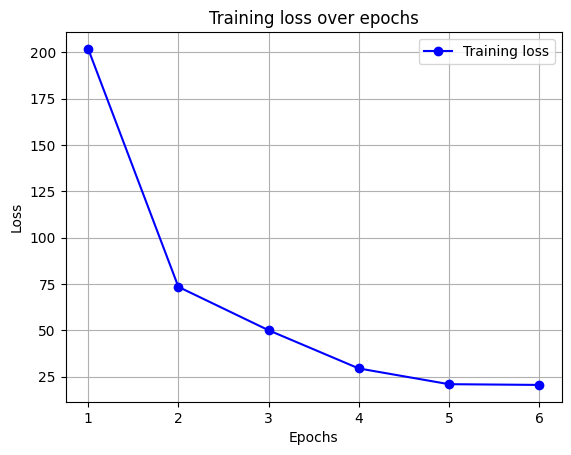

[I 2024-11-30 14:18:17,827] Trial 0 finished with value: 20.543815218314286 and parameters: {'num_epochs': 6, 'batch_size': 64, 'dropout': 0.33739463789901497, 'optimizer': 'sgd'}. Best is trial 0 with value: 20.543815218314286.


Epoch 1/20, Loss: 209.1991442170849
Epoch 2/20, Loss: 75.02885184608213
Epoch 3/20, Loss: 50.91826292992548
Epoch 4/20, Loss: 38.81547002242033
Epoch 5/20, Loss: 26.487858541878524
Epoch 6/20, Loss: 20.424735556683206
Epoch 7/20, Loss: 11.875441621342029
Epoch 8/20, Loss: 8.714749767522397
Epoch 9/20, Loss: 9.267438128256186
Epoch 10/20, Loss: 5.258554094325292
Epoch 11/20, Loss: 10.307931157147042
Epoch 12/20, Loss: 12.922611626049841
Epoch 13/20, Loss: 3.894879676779128
Epoch 14/20, Loss: 4.047894749419363
Epoch 15/20, Loss: 0.5072168091043145
Epoch 16/20, Loss: 6.141874292659907
Epoch 17/20, Loss: 3.723396859055478
Epoch 18/20, Loss: 6.350293581534432
Epoch 19/20, Loss: 7.1421965444124105
Epoch 20/20, Loss: 2.5446697686702198


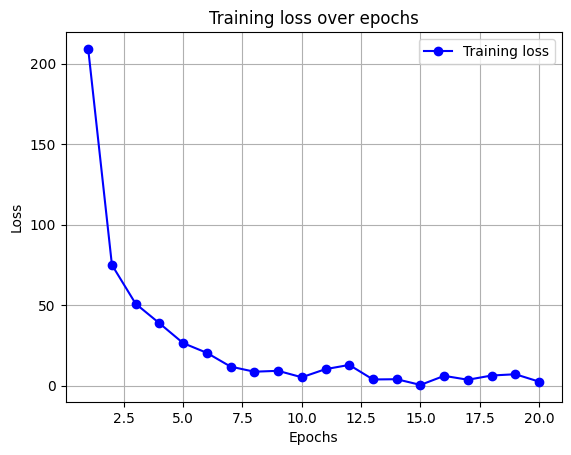

[I 2024-11-30 14:47:23,891] Trial 1 finished with value: 2.5446697686702198 and parameters: {'num_epochs': 20, 'batch_size': 16, 'dropout': 0.3176366560213247, 'optimizer': 'adam'}. Best is trial 1 with value: 2.5446697686702198.


Epoch 1/9, Loss: 215.19744299556484
Epoch 2/9, Loss: 86.95851399999397
Epoch 3/9, Loss: 56.435914287400244
Epoch 4/9, Loss: 38.5358475018312
Epoch 5/9, Loss: 34.624500449344076
Epoch 6/9, Loss: 18.771067181314137
Epoch 7/9, Loss: 15.145473682778208
Epoch 8/9, Loss: 17.59851124188504
Epoch 9/9, Loss: 6.446620802861717


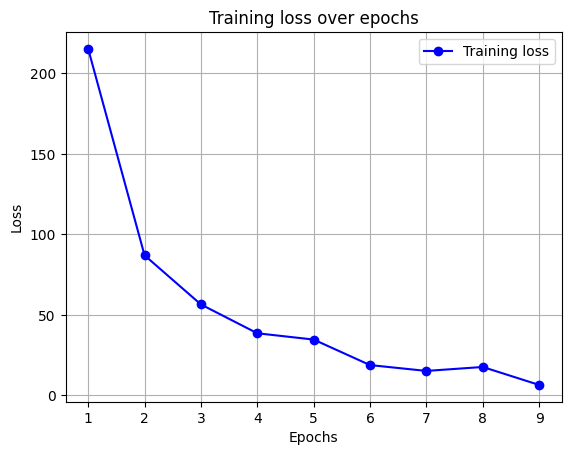

[I 2024-11-30 15:16:06,053] Trial 2 finished with value: 6.446620802861717 and parameters: {'num_epochs': 9, 'batch_size': 16, 'dropout': 0.3572911762299883, 'optimizer': 'adam'}. Best is trial 1 with value: 2.5446697686702198.


Best parameters: {'num_epochs': 20, 'batch_size': 16, 'dropout': 0.3176366560213247, 'optimizer': 'adam'}


In [13]:
# function for hyperparameter tuning 
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Args:
        trial: Optuna trial object to suggest hyperparameters.
    Returns:
        float: The final loss after training.
    """

    # Define the hyperparameter search space
    num_epochs = trial.suggest_int("num_epochs", 5, 20)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])

    # Call the training function with suggested hyperparameters
    losses, _ = train_spacy_model(
        train_data=x_train,
        num_epochs=num_epochs,
        batch_size=batch_size,
        dropout=dropout,
        optimizer_name=optimizer_name
    )

    plt.plot(range(1, num_epochs + 1), losses, marker='o', color='b', label='Training loss')
    plt.title('Training loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    return losses[-1]  # Return the final epoch loss for minimization
study = optuna.create_study(direction="minimize")  # Minimize the loss
study.optimize(objective, n_trials=3)  # Run 10 trials

print(f"Best parameters: {study.best_params}")

> training the model with the best parameters 

Epoch 1/20, Loss: 208.17356038996286
Epoch 2/20, Loss: 77.8188521856859
Epoch 3/20, Loss: 52.54541843864104
Epoch 4/20, Loss: 42.79810266014245
Epoch 5/20, Loss: 27.18146172031064
Epoch 6/20, Loss: 18.556480035535127
Epoch 7/20, Loss: 15.141638880287639
Epoch 8/20, Loss: 14.8203603394513
Epoch 9/20, Loss: 14.084439991928122
Epoch 10/20, Loss: 11.054810242875442
Epoch 11/20, Loss: 8.508905134596258
Epoch 12/20, Loss: 7.640826978009673
Epoch 13/20, Loss: 3.822125416808096
Epoch 14/20, Loss: 4.220030094766148
Epoch 15/20, Loss: 3.090724264005191
Epoch 16/20, Loss: 6.868075742379492
Epoch 17/20, Loss: 2.537453126356159
Epoch 18/20, Loss: 2.4636215487880144
Epoch 19/20, Loss: 1.9900292765328351
Epoch 20/20, Loss: 1.5141763658793757
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1424
        spam       0.97      0.83      0.90       248

    accuracy                           0.97      1672
   macro avg       0.

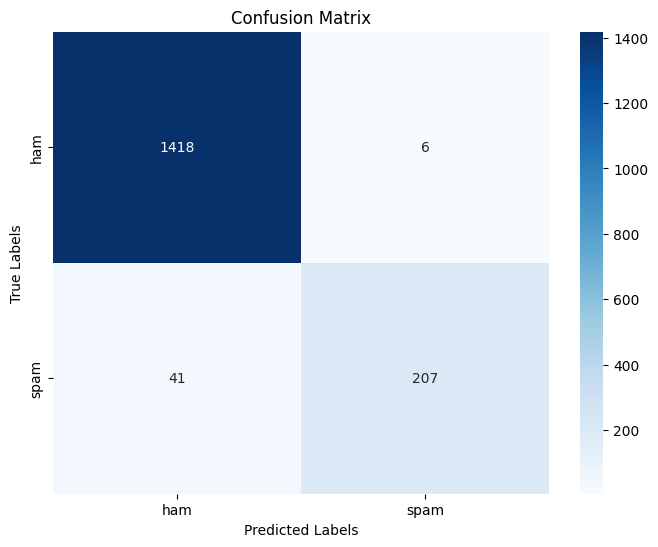

Accuracy of the best model: 97.19
classification report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1424
        spam       0.97      0.83      0.90       248

    accuracy                           0.97      1672
   macro avg       0.97      0.92      0.94      1672
weighted avg       0.97      0.97      0.97      1672



In [14]:
def train_final_model(best_params, train_data):
    """
    Train the final model using the best parameters found from Optuna.
    """
    nlp = spacy.blank("en")  # Initialize a blank English model
    # Add text classification pipe if not already added
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.add_pipe('textcat', last=True)
    else:
        textcat = nlp.get_pipe('textcat')
    for label in unique_labels:
        textcat.add_label(label)
    
    optimizer = nlp.begin_training()  # Start training

    # Train the model
    epoch_losses = []
    for epoch in range(best_params['num_epochs']):
        losses = {}
        random.shuffle(train_data)  # Shuffle the data
        batches = spacy.util.minibatch(train_data, size=best_params['batch_size'])

        for batch in batches:
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.update([example], drop=best_params['dropout'], losses=losses)

        total_loss = losses.get("textcat", 0)
        epoch_losses.append(total_loss)
        print(f"Epoch {epoch + 1}/{best_params['num_epochs']}, Loss: {total_loss}")

    return nlp  # Return the trained model


def evaluate_model(model, test_data, class_labels):
    """
    Evaluate the accuracy of the trained model on the test data.
    """
    y_true = []
    y_pred = []
    
    for text, annotations in test_data:
        # Extract true label
        true_label = max(annotations['cats'], key=annotations['cats'].get)
        y_true.append(true_label)
        
        # Get predicted label
        doc = model(text)
        predicted_label = max(doc.cats, key=doc.cats.get)
        y_pred.append(predicted_label)
    
    # Ensure consistency
    if len(y_true) != len(y_pred):
        raise ValueError(f"Inconsistent lengths: y_true={len(y_true)}, y_pred={len(y_pred)}")
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=class_labels)
    cm = confusion_matrix(y_true, y_pred)
    
    print("Classification Report:\n", class_report)
    print("Confusion Matrix:\n", cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    return acc, class_report, cm

class_label = unique_labels    
# train the model with the best training parameters
best_model = train_final_model(study.best_params, x_train)  # Train the model with the best parameters

# evaluate the accuracy of the best model on the test data
best_model_acc, class_report, cm = evaluate_model(best_model, x_test, class_labels=class_label)  # Evaluate the model on the test
print(f"Accuracy of the best model: {best_model_acc*100:.2f}")  # Print the accuracy of the best model
print("classification report:\n", class_report)  # Print the classification report of the best model

### Text classification using SVM 

shape of TF-IDF is:  (5572, 7320)
accuracy score of our model: 97.67
classification_report is
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1453
        spam       0.98      0.84      0.90       219

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672

confusion matrix
 [[1449    4]
 [  35  184]]


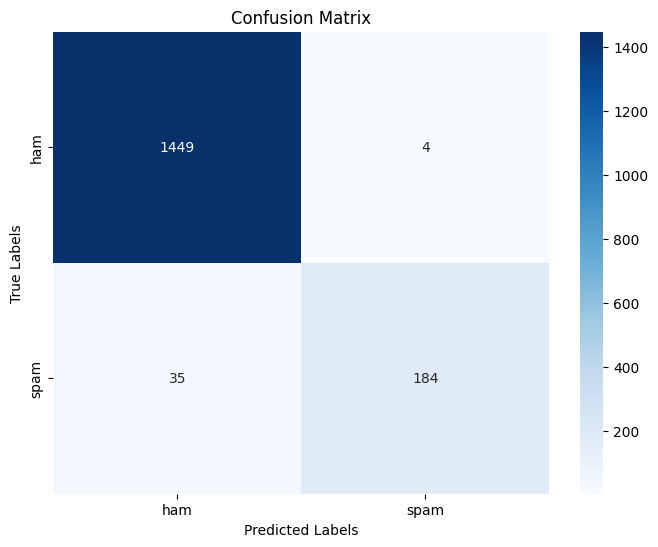

In [15]:
 # convert text to list 
corpus = spams_df['Cleaned_sentences'].astype(str).tolist()

#create and fit the tfidif_vectorizer
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(corpus) # used in our traininig data
print("shape of TF-IDF is: ", tfidf_vectorizer.transform(corpus).shape)

X_train, x_test, y_train, y_test = train_test_split(X, spams_df['v1'],
                                                    test_size=0.3, random_state=42)

# training the SVM model 
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# making predictions on test data
y_pred = svm_model.predict(x_test)

# evaluating the model
print(f"accuracy score of our model: {accuracy_score(y_test, y_pred)*100:.2f}")
print("classification_report is\n", classification_report(y_test, y_pred))


# printing the confusion matrix 
conf_mat = confusion_matrix(y_test, y_pred)
print(f"confusion matrix\n {conf_mat}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Hyperparameter Tuning for SVM 

[I 2024-11-30 16:17:26,177] A new study created in memory with name: no-name-b489de65-95cc-49e3-a47d-fd98dcfc990e
C:\Users\aondo\AppData\Local\Temp\ipykernel_34420\2077146874.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e5)


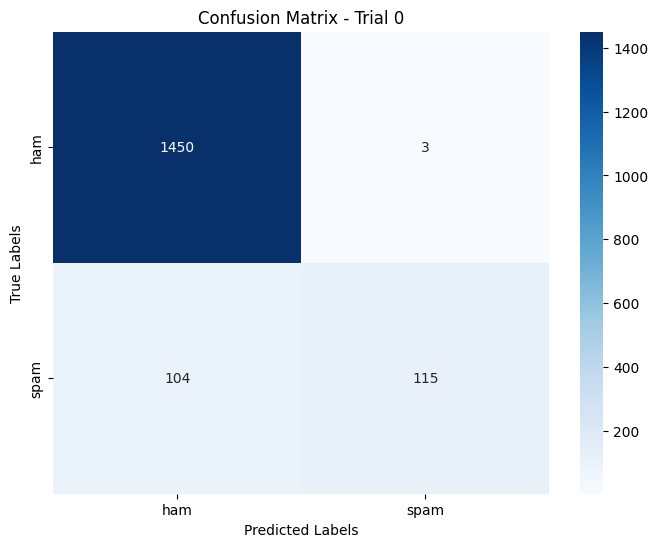

[I 2024-11-30 16:17:27,813] Trial 0 finished with value: 0.9360047846889952 and parameters: {'kernel': 'poly', 'C': 1.8210818760557066}. Best is trial 0 with value: 0.9360047846889952.
C:\Users\aondo\AppData\Local\Temp\ipykernel_34420\2077146874.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e5)


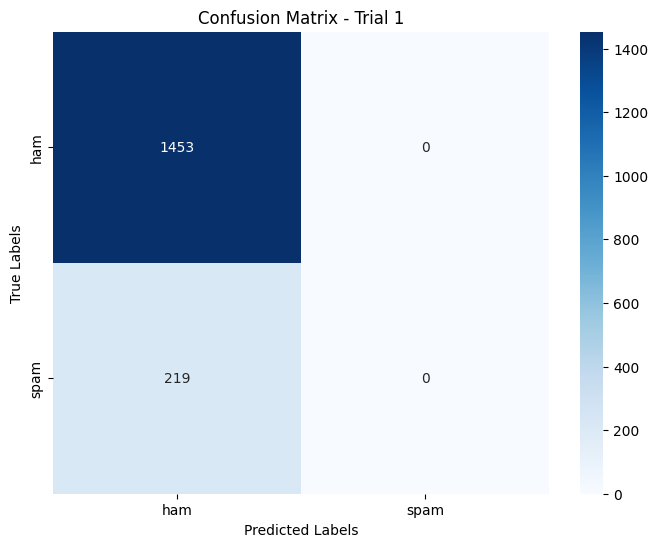

[I 2024-11-30 16:17:29,291] Trial 1 finished with value: 0.8690191387559809 and parameters: {'kernel': 'poly', 'C': 0.05925454998740193}. Best is trial 0 with value: 0.9360047846889952.


Best parameters: {'kernel': 'poly', 'C': 1.8210818760557066}
Best model accuracy: 93.60
Classification report for best model:
               precision    recall  f1-score   support

         ham       0.93      1.00      0.96      1453
        spam       0.97      0.53      0.68       219

    accuracy                           0.94      1672
   macro avg       0.95      0.76      0.82      1672
weighted avg       0.94      0.94      0.93      1672



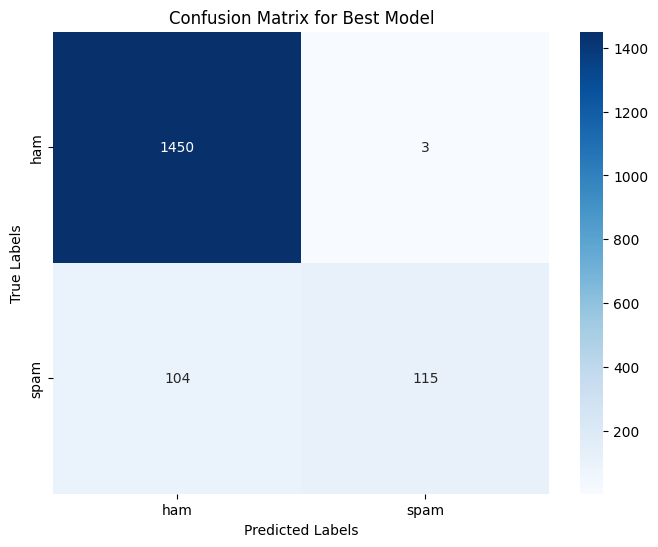

In [17]:
def objective(trial):
    # Hyperparameters to tune
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    C = trial.suggest_loguniform('C', 1e-4, 1e5)

    # Create and train the SVM model with the suggested hyperparameters
    model = SVC(kernel=kernel, C=C)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(x_test)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Plot confusion matrix (optional)
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix - Trial {trial.number}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Return accuracy for optimization
    return accuracy

# Create the Optuna study
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=2)  # Run 2 trials to optimize hyperparameters

# Get the best parameters and print them
print(f"Best parameters: {study.best_params}")

# Now train the best model using the best parameters from Optuna
best_params = study.best_params
best_model = SVC(C=best_params['C'], kernel=best_params['kernel'])
best_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred_best = best_model.predict(x_test)

# Evaluate the model with a classification report and confusion matrix
print(f"Best model accuracy: {accuracy_score(y_test, y_pred_best) * 100:.2f}")
print("Classification report for best model:\n", classification_report(y_test, y_pred_best))

# Confusion matrix for the best model
conf_mat_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_best, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix for Best Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Analysis and Conclusion 

1. Analyze the results obtained from various models and hyperparameter configurations.
      SpaCy Text Classification: The project used a custom architecture with a textcat pipeline.
      Support Vector Machine (SVM): A secondary model was trained using TF-IDF vectors for feature representation.


    Hyperparameter Tuning: The hyperparameters (batch size, dropout rate, optimizer) were optimized using Optuna.
    The best parameters found were:
        Num epochs: 20
        Batch size: 64
        Dropout: ~0.1
        Optimizer: Adam
    Results:
        The SpaCy model showed steady improvements in loss over training epochs with the best model achieving an accuracy of 97.19%.
        SVM achieved an accuracy of 97.67% with a linear kernel. The best model achieved an accuracy of 93.19% with a poly kernel.

2. Discuss the impact of SpaCy in comparison to other models in terms of performance and computational efficiency.
    Spacy achieved decent results but struggled with class imbalance, especially in detecting the ham class.
    SVM performed better in this regard, achieving higher accuracy and better handling of class imbalance

    **Computational Efficiency**: Spacy allows for efficeint processing of text data due to its ability to handle tokenization, entity recognition. I talso allows adding and updating pipelines (like textcat). However the training time for custom data was slower. It also had a higher overhead in terms of memory usage. SVM was faster in training and had lower memory usage.

    The SVM model was easier to implement than the SpaCy model and achieved better results. However, the SpaCy model was more flexible and allowed for custom text data.

3. Draw conclusions on the suitability of different models and hyperparameter settings for the given dataset and task.
    For pure text classification tasks, SVM is a good choice due to its simplicity and ease of implementation.However, for more complex tasks that require entity recognition, Spacy is a better choice due to its ability to handle tokenization and entity recognition. The choice of hyperparameters also plays a significant role in achieving good results. In this project, the optimal hyperparameters were found using Optuna, which significantly improved the performance of the model by helping us select the best parameters for each model.